In [158]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.display import display, clear_output
import time

class GridWorldEnv(gym.Env):
    def __init__(self, n=5, start_pos=(0, 0), goal_pos=None, block_percentage=5):
        super(GridWorldEnv, self).__init__()
        
        self.n = n
        self.grid_size = (n, n)
        self.path = []
        
        # Define the action space: 0 = left, 1 = right, 2 = up, 3 = down
        self.action_space = spaces.Discrete(4)
        
        # Define the observation space, which is the position of the agent on the grid
        '''self.observation_space = spaces.Tuple((
            spaces.Discrete(n),
            spaces.Discrete(n)
        ))'''
        
        # Set the starting position of the agent
        self.start_pos = start_pos
        self.current_pos = self.start_pos
        
        # Set the goal position
        self.goal_pos = goal_pos if goal_pos else (n-1, n-1)
        
        # Set the blocked cells, generate random blocked cells
        num_cells = n * n
        num_blocked = int((block_percentage / 100) * num_cells)
        
        self.blocked_cells = []
        while len(self.blocked_cells) < num_blocked:
            cell = (random.randint(0, n-1), random.randint(0, n-1))
            if cell != self.start_pos and cell != self.goal_pos and cell not in self.blocked_cells:
                self.blocked_cells.append(cell)
        
        # Create grid with obstacles
        self.grid = np.zeros(self.grid_size)
        for cell in self.blocked_cells:
            self.grid[cell] = -1  # Mark blocked cells as -1
        
    def reset(self):
        # Reset agent's position to start
        self.path.clear()
        self.current_pos = self.start_pos
        return self.current_pos

    def step(self, action):
        x, y = self.current_pos

        # Take action based on the agent's current position
        if action == 0:  # Left
            y = max(0, y - 1)
        elif action == 1:  # Right
            y = min(self.n - 1, y + 1)
        elif action == 2:  # Up
            x = max(0, x - 1)
        elif action == 3:  # Down
            x = min(self.n - 1, x + 1)
        
        next_pos = (x, y)

        # Check if the next position is blocked
        #if next_pos in self.blocked_cells:
        #    next_pos = self.current_pos  # Stay in the same position if blocked

        # Set the new current position
        self.current_pos = next_pos

        # Check if the agent reached the goal
        if self.current_pos == self.goal_pos:
            reward = 1000  # Reward for reaching the goal
            done = True
        elif self.current_pos in self.blocked_cells:
            reward = -100  # Small penalty for each step taken
            done = False
        else:
            reward = -1  # Small penalty for each step taken
            done = False
            
        self.path.append(self.current_pos)

        return self.current_pos, reward, done, {}

    
    def render(self, mode='human'):
        grid = np.copy(self.grid)

        for p in self.path:
            grid[p] = 4
        
        # Mark the agent's position
        grid[self.current_pos] = 1

        # Mark the agent's position
        grid[self.start_pos] = 3
        
        # Mark the goal position
        grid[self.goal_pos] = 2

        # Display the grid as an image
        cmap = colors.ListedColormap([
            'black',              # Black color
            'white',              # White color
            'red',                # Red color
            'green',             # Yellow color
            (0.1, 0.7, 0.7, 0.1) # Transparent gray
        ])
        bounds = [-1, 0, 1, 2, 3, 4]
        norm = colors.BoundaryNorm(bounds, cmap.N)

        fig, ax = plt.subplots()
        ax.imshow(grid, cmap=cmap, norm=norm)

        # Remove default grid lines and ticks
        ax.set_xticks(np.arange(self.n) + 0.5, minor=True)
        ax.set_yticks(np.arange(self.n) + 0.5, minor=True)
        ax.grid(which="minor", color="black", linestyle='-', linewidth=1)  # Square boundaries

        ax.set_xticks([])  # Remove tick marks
        ax.set_yticks([])  # Remove tick marks

        # Render agent, goal, and blocked cells in the center of the squares
        for i in range(self.n):
            for j in range(self.n):
                if (i, j) == self.current_pos:
                    ax.text(j, i, 'A', ha='center', va='center', fontsize=12, color='green')
                elif (i, j) == self.start_pos:
                    ax.text(j, i, 'S', ha='center', va='center', fontsize=12, color='green')  # Starting point
                elif (i, j) == self.goal_pos:
                    ax.text(j, i, 'G', ha='center', va='center', fontsize=12, color='red')
                elif (i, j) in self.blocked_cells:
                    ax.text(j, i, 'X', ha='center', va='center', fontsize=12, color='black')

        plt.title(f"Agent at {self.current_pos}, Goal at {self.goal_pos}")
        display(plt.gcf())
        clear_output(wait=True)
        tic = (10/(n**2))
        time.sleep(tic)
        plt.close()

    def show_final(self):
        grid = np.copy(self.grid)

        for p in self.path:
            grid[p] = 4
        
        # Mark the agent's position
        grid[self.current_pos] = 1
        
         # Mark the agent's position
        grid[self.start_pos] = 3

        # Mark the goal position
        grid[self.goal_pos] = 2

        # Display the grid as an image
        cmap = colors.ListedColormap([
            'black',              # Black color
            'white',              # White color
            'red',                # Red color
            'green',             # Yellow color
            (0.1, 0.7, 0.7, 0.1) # Transparent gray
        ])
        bounds = [-1, 0, 1, 2, 3, 4]
        norm = colors.BoundaryNorm(bounds, cmap.N)

        fig, ax = plt.subplots()
        ax.imshow(grid, cmap=cmap, norm=norm)

        # Remove default grid lines and ticks
        ax.set_xticks(np.arange(self.n) + 0.5, minor=True)
        ax.set_yticks(np.arange(self.n) + 0.5, minor=True)
        ax.grid(which="minor", color="black", linestyle='-', linewidth=1)  # Square boundaries

        ax.set_xticks([])  # Remove tick marks
        ax.set_yticks([])  # Remove tick marks

        # Render agent, goal, and blocked cells in the center of the squares
        for i in range(self.n):
            for j in range(self.n):
                if (i, j) == self.current_pos:
                    ax.text(j, i, 'A', ha='center', va='center', fontsize=12, color='green')
                elif (i, j) == self.start_pos:
                    ax.text(j, i, 'S', ha='center', va='center', fontsize=12, color='green')  # Starting point
                elif (i, j) == self.goal_pos:
                    ax.text(j, i, 'G', ha='center', va='center', fontsize=12, color='red')
                elif (i, j) in self.blocked_cells:
                    ax.text(j, i, 'X', ha='center', va='center', fontsize=12, color='black')

        plt.title(f"Agent at {self.current_pos}, Goal at {self.goal_pos}")
        plt.show()
        
def plot_q_table(q_table):
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    action_labels = ['Action 0', 'Action 1', 'Action 2', 'Action 3']

    # Loop over each action and plot the heatmap in the appropriate subplot
    for action_index in range(4):
        # Select the subplot in the 2x2 grid
        ax = axs[action_index // 2, action_index % 2]
        
        # Extract Q-values for the current action index
        q_values = q_table[:, :, action_index]
        
        # Plot the heatmap for the current action
        heatmap = ax.imshow(q_values, cmap='viridis', origin='upper', extent=[0, n, 0, n])
        ax.set_title(f"Q-values for {action_labels[action_index]}")
        
        # Add color bar
        fig.colorbar(heatmap, ax=ax)
        
        # Set axis labels and ticks
        ax.set_xticks(np.arange(n))
        ax.set_yticks(np.arange(n))
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

    # Adjust layout for better display
    plt.tight_layout()
    plt.show()


path=[]

def run_exploit(env, q_table, p=(0, 0)):
    max_try = 0
    state = env.reset()
    env.current_pos = p
    state = p
    done = False
    env.render()
    path.clear()
    
    while not done and max_try < 1000:
        path.append(state)
        action = np.argmax(q_table[state[0], state[1]])
        state, _, done, _ = env.step(action)
        env.render()
        max_try += 1
    env.show_final()
    
def run_explore(env, q_table, eps=0.2, p=(0, 0)):
    max_try = 0
    state = env.reset()
    env.current_pos = p
    state = p
    done = False
    env.render()
    path.clear()
    
    while not done and max_try < 1000:
        path.append(state)
        if random.uniform(0, 1) < eps:
            action = env.action_space.sample()  # Explore action space
        else:
            action = np.argmax(q_table[state[0], state[1]])  # Exploit learned values
        state, _, done, _ = env.step(action)
        env.render()
        max_try += 1
    env.show_final()

In [183]:
# Define grid size and blocked cells percentage
n = 6
start_pos = (0, 0)
goal_pos = (n-1, n-1)
block_percentage = 15

env = GridWorldEnv(n=n, start_pos=start_pos, goal_pos=goal_pos, block_percentage=block_percentage)

# Q-learning parameters
q_table = np.zeros((n, n, env.action_space.n))
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_min = 0.1
epsilon_decay = 0.995
num_episodes = 5000
max_steps = 500

rewards_per_episode = []

t = 1
# Q-learning algorithm
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    
    for step in range(max_steps):
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore action space
        else:
            action = np.argmax(q_table[state[0], state[1]])  # Exploit learned values
        
        next_state, reward, done, _ = env.step(action)
        
        # Update Q-value
        q_table[state[0], state[1], action] = q_table[state[0], state[1], action] + alpha * (
            reward + gamma * np.max(q_table[next_state[0], next_state[1]]) - q_table[state[0], state[1], action]
        )
        
        state = next_state
        total_reward += reward
        
        if done:
            break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon_decay * epsilon)

    if (episode + 1) % int(20/epsilon) - 20 == 0:
        print(f"Episode {episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon}")
    
    rewards_per_episode.append(total_reward)
    
print("Training finished!")
print("final qtable shape:", q_table.shape)

Episode 20, Total Reward: -449, Epsilon: 0.9046104802746175
Episode 44, Total Reward: 665, Epsilon: 0.8020760579717637
Episode 45, Total Reward: 978, Epsilon: 0.798065677681905
Episode 78, Total Reward: 656, Epsilon: 0.6763948591909945
Episode 137, Total Reward: 877, Epsilon: 0.5032248303978422
Episode 140, Total Reward: 989, Epsilon: 0.49571413690105054
Episode 326, Total Reward: 987, Epsilon: 0.19513012515638165
Episode 620, Total Reward: 989, Epsilon: 0.1
Episode 820, Total Reward: 890, Epsilon: 0.1
Episode 1020, Total Reward: 991, Epsilon: 0.1
Episode 1220, Total Reward: 990, Epsilon: 0.1
Episode 1420, Total Reward: 991, Epsilon: 0.1
Episode 1620, Total Reward: 989, Epsilon: 0.1
Episode 1820, Total Reward: 989, Epsilon: 0.1
Episode 2020, Total Reward: 991, Epsilon: 0.1
Episode 2220, Total Reward: 989, Epsilon: 0.1
Episode 2420, Total Reward: 991, Epsilon: 0.1
Episode 2620, Total Reward: 991, Epsilon: 0.1
Episode 2820, Total Reward: 991, Epsilon: 0.1
Episode 3020, Total Reward: 989,

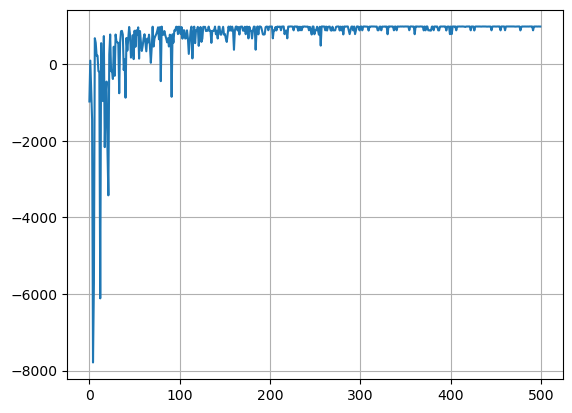

In [184]:
plt.plot(rewards_per_episode[:500])
plt.grid(True)
plt.show()

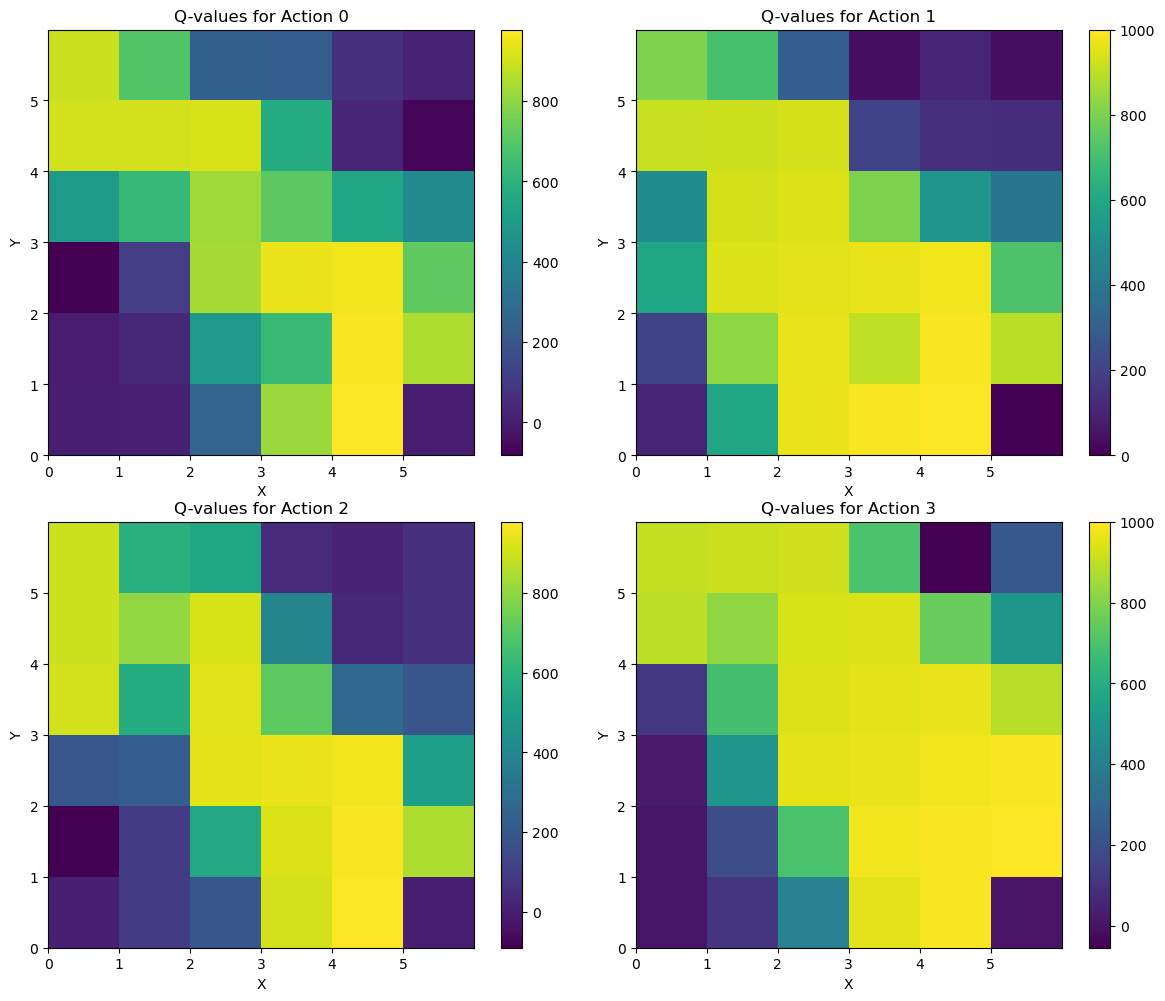

In [185]:
plot_q_table(q_table)

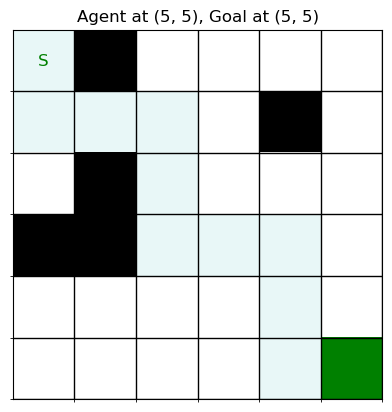

In [187]:
run_exploit(env, q_table)

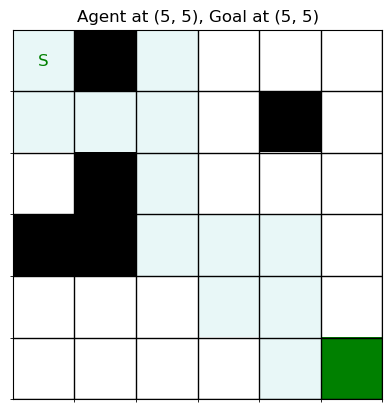

In [189]:
run_explore(env, q_table, eps=.3) # 30% case explore